# Introduction
This project looks at manufacturing process data **(i.e. features)** and the yield **(i.e target)** of a drug , in hopes of finding a pattern or connection between the features and the target, i.e. building an accurate model. 

The following techniques will be used to build a model:
* **Data Cleaning** - dropped NAs and outliers after confirming it's ok to drop them, this was done in a separate notebook
* **Feature Selection** - analyze scatter plots of features/targets, and use univariate feature selection techniques (SelectKBest)
* **Clustering** - get new features
* **Regression** - build a model to predict the target's value
* **Neural Network** - build a simple feedforward neural network
* **Classification**- build a model to predict the target's class
* **Cross Validiation** - determine legitimacy of model

In [168]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
sns.set_context('notebook')

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn import feature_selection
from sklearn import metrics
from sklearn import grid_search
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import scipy.stats as spStats

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, RMSprop

import timeit
import pickle
from sklearn.externals import joblib
pd.set_option('display.max_columns',100)

# Data Summary
Unfortunately, I cannot explain the details about the data I used in this study, but basically there are 30+ features that I can choose from, and two target values: One numerical target for regression, and one categorical for classification. Here is what the data looks like.

In [2]:
processed_df = pd.read_excel('processed_data.xlsx')
processed_df.head(1)

,Month,Year,Week No.,Date,Lot Number,Cut Lot Number,Bag/Bottle,PCA (%),PPT G (kg),CPP (kg),g PPT G/kg CPP,Total Protein (g/dL),CUNO Filt (kg),VP (L),Diluted CPP (kg),Dilution (kg),CPP IgG before Fr1,Cuno IgG FP6,Diluted % Efficiency,CPP (L),G Conv (g IgG/Kg PPT G),Yield CP (WT),Yield_Label,Yield_Label_2,Yield VP (WT),I - Final pH,I - Aging,II+III After Alc pH,II+III After Alc Titer,II+III - Final pH,II+III - Aging,II+III Paste Wt,Buffer 1 Amt,Extraction Ratio,Extract - Final pH,Extract - Aging,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT
0,1,2014,2,2014-01-06,LB1499004,LB149004,Bags,90.1,112.3,7479.7,15.013971,0.497,7839,7493.656,8241.938,762.238,500.0,466.5,0.909571,7297.268293,290.5,4.470598,acceptable,below mean,4.353436,7.22,7.505833,6.92,1.5,6.91,19.833333,701,6288.1,19.584228,5.07,3.326389,6.54,4.48,6.98,15.908333,8.6925,7.024167,14.136389,10.084722,-0.001111,39.180278


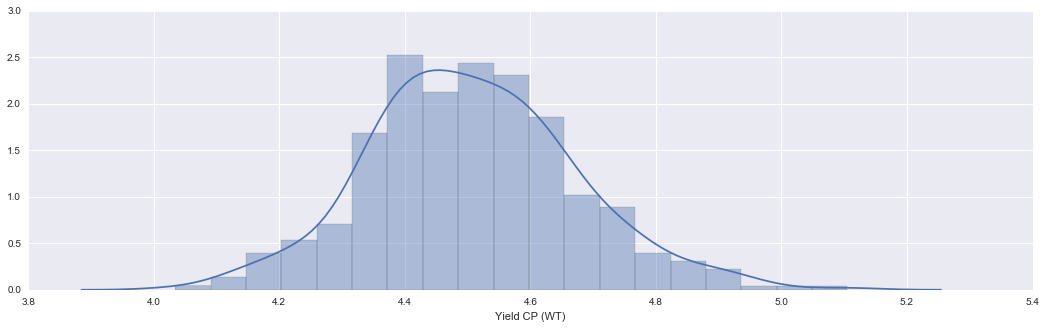

In [3]:
plt.figure(figsize=(18,5))
sns.distplot(processed_df['Yield CP (WT)'])

# Bag/Bottle Dummy Variables
There are 3 containers that the raw material is shipped in. I figure these can be used as categorical features.

In [4]:
Counter(processed_df['Bag/Bottle'])

Counter({u'Bags': 231, u'Bags/NMF': 38, u'Bottle': 131})

In [5]:
processed_df = pd.read_excel('processed_data.xlsx')
bag_bottle_dummies = pd.get_dummies(processed_df['Bag/Bottle'],prefix='bag_or_bottle_label')
processed_df = processed_df.join(bag_bottle_dummies)

# Features versus Target Plots
In features vs target plots, I'm looking for a linear trend. Even if there are groups, I can't use clustering algorithm to create new features because for any new data point, I won't have the target value to enter into a classification algorithm.

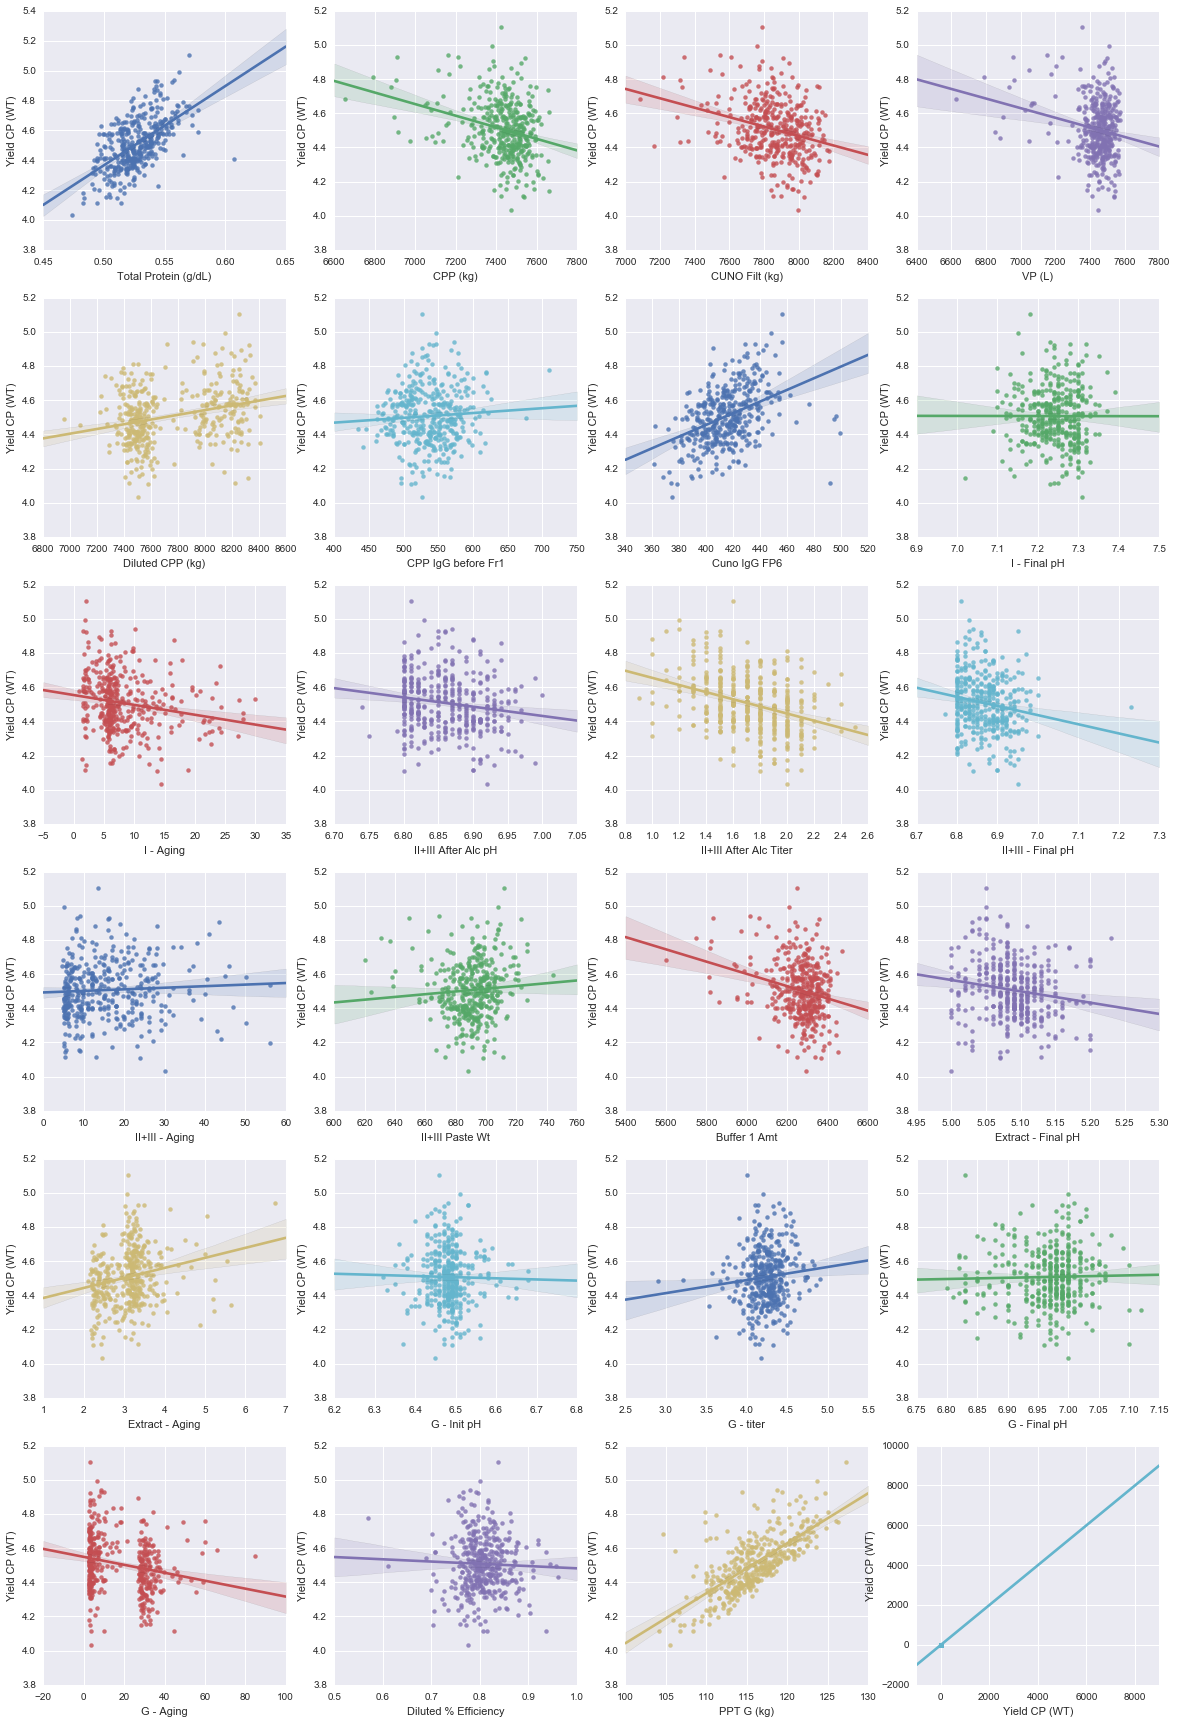

In [6]:
plotting_cols = [
#                 'Bag/Bottle',
                'Total Protein (g/dL)',
                'CPP (kg)',
                'CUNO Filt (kg)',
                'VP (L)',
                'Diluted CPP (kg)',
                'CPP IgG before Fr1',
                'Cuno IgG FP6',
                'I - Final pH',
                'I - Aging',
                'II+III After Alc pH',
                'II+III After Alc Titer',
                'II+III - Final pH',
                'II+III - Aging',
                'II+III Paste Wt',
                'Buffer 1 Amt',
                'Extract - Final pH',
                'Extract - Aging',
                'G - Init pH',
                'G - titer',
                'G - Final pH',
                'G - Aging',
                #'TD_CT',
                #'FrI_PPT_CT',
                #'FrII_PPT_CT',
                #'V13_Sep_CT',
                #'G_PPT_CT',
                'Diluted % Efficiency',
                'PPT G (kg)',
                'Yield CP (WT)'
               ]

target = 'Yield CP (WT)'
numOfRows = 6
numOfCols = 4
figure,axes = plt.subplots(nrows=numOfRows,ncols=numOfCols,figsize=(20,30),sharex=False)
x = 0
rValues_VS_Yield = {}
for r in range(numOfRows):
    for c in range(numOfCols):
        if x <len(plotting_cols):
            sns.regplot(data=processed_df,x=plotting_cols[x],y=target,ax=axes[r,c])
            rValues_VS_Yield[plotting_cols[x]] = spStats.pearsonr(processed_df[target],
                                                                  processed_df[plotting_cols[x]]) 
            x = x + 1
        else:
            pass

# Feature vs Feature Plots
In feature vs feature plots, I'm looking for groups so I can potentially use clustering algorithm to create new features. I am also looking for strong linear relationships so I won't feed in two highly correlated features into the model. 

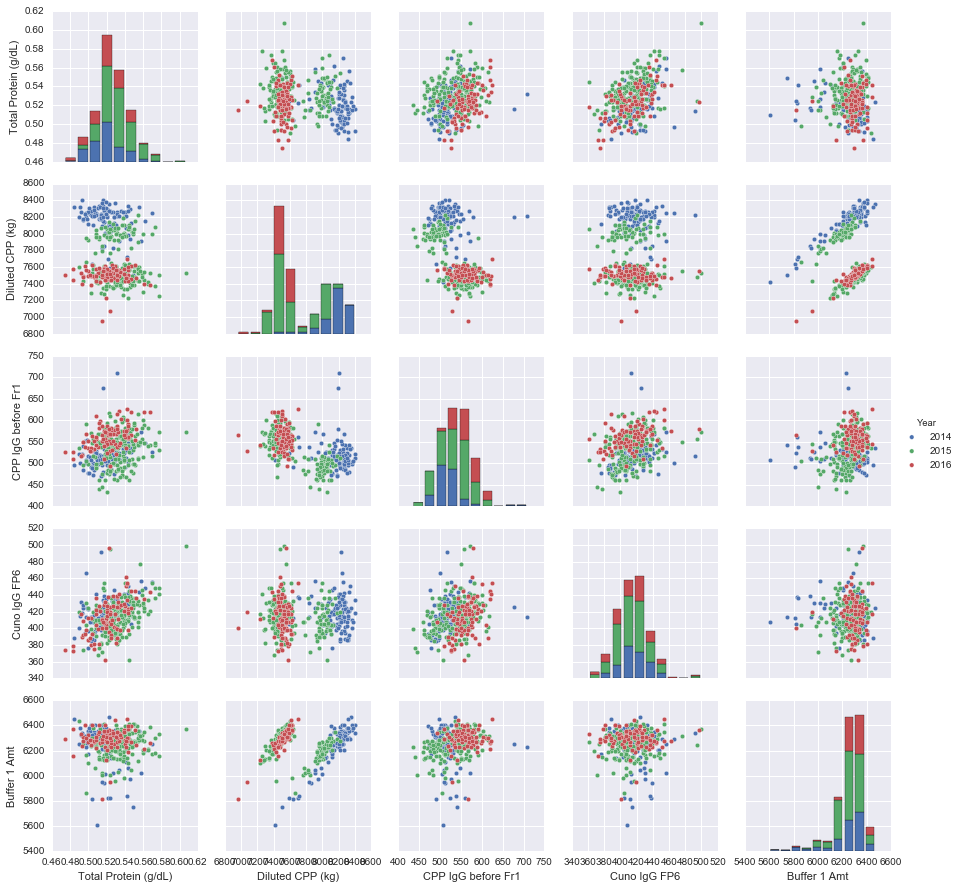

In [7]:
sns.pairplot(data=processed_df,
             vars=[
#                     'Bag/Bottle',
                    'Total Protein (g/dL)',
#                     'CPP (kg)',
#                     'CUNO Filt (kg)',
#                     'VP (L)',
                    'Diluted CPP (kg)',
                    'CPP IgG before Fr1',
                    'Cuno IgG FP6',
#                     'I - Final pH',
#                     'I - Aging',
#                     'II+III After Alc pH',
#                     'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
                    'Buffer 1 Amt',
#                     'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'G_PPT_CT',
#                     'Diluted % Efficiency',
#                     'Yield CP (WT)'
                    ],
             hue='Year'
            )


# Using Clustering Algorithm to Get New Features

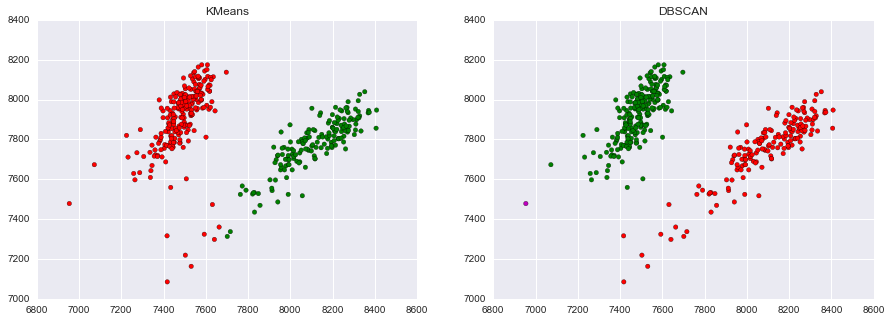

In [8]:
def get_colors(labels):
    pallete = 'rgbym'
    colors = []
    for i in labels:
        colors.append(pallete[i])
    return colors

first_feature = 'Diluted CPP (kg)'
second_feature = 'CUNO Filt (kg)'

f, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize=(15,5))

model = KMeans(n_clusters=2)
model.fit(processed_df[[first_feature,second_feature]])

axes[0].scatter(x=processed_df[first_feature],y=processed_df[second_feature], c=get_colors(model.labels_))
axes[0].set_title('KMeans')

model = DBSCAN(eps=170)
model.fit(processed_df[[first_feature,second_feature]])

axes[1].scatter(x=processed_df[first_feature],y=processed_df[second_feature], c=get_colors(model.labels_))
axes[1].set_title('DBSCAN')

After tweaking the parameters a bit, DBSCAN gave me the best clusters. Notice that in KMeans, several data points in the right cluster is labeled as the same as the one on the left. DBSCAN had much better separation with 1 outlier identified.

# Adding New Features from Clustering Algorithm

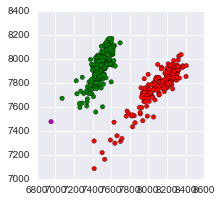

In [9]:
# Actually storing the labels. The cells above is my sandbox to look at the clustering results.
model = DBSCAN(eps=170)
model.fit(processed_df[['Diluted CPP (kg)','CUNO Filt (kg)']])

plt.figure(figsize=(3,3))
plt.scatter(x=processed_df['Diluted CPP (kg)'],y=processed_df['CUNO Filt (kg)'], c=get_colors(model.labels_))

processed_df['DilutedCPPvsCUNOFilt'] = model.labels_
dummies = pd.get_dummies(processed_df['DilutedCPPvsCUNOFilt'],prefix='DilutedCPPvsCUNOFilt')
processed_df = processed_df.join(dummies)

Adding a percentage feature, just to see if it will be of use later on.

In [10]:
processed_df['Buffer 1 Percentage'] = (processed_df['II+III Paste Wt']/processed_df['Buffer 1 Amt'])*100

# Converting the target numerical variable into a categorical variable
This is in preparation for classification models.

The add labels to the numerical target, I calculated the mean and standard deviation, and marked each value as either:
* More than 1 std below the mean
* Within 1 std below the mean
* Within than 1 std above the mean
* More than 1 std above the mean

In [11]:
# Calculating yield label column based on only 2015 and 2016 data
tempMean = np.mean(processed_df[processed_df['Year']!=2014]['Yield CP (WT)'])
tempStd = np.std(processed_df[processed_df['Year']!=2014]['Yield CP (WT)'])

tempList = []

for i in processed_df['Yield CP (WT)']:
    if i >= (tempMean+tempStd):
        tempList.append('above 1')
    elif i >= (tempMean):
        tempList.append('above mean')
    elif i >= (tempMean-tempStd):
        tempList.append('below mean')
    else:
        tempList.append('below 1')

processed_df['15and16_yield_label'] = tempList
processed_df[['Yield CP (WT)','15and16_yield_label']].head()

# Count of my new labels
print Counter(processed_df[processed_df['Year']!=2014]['15and16_yield_label'])
processed_df[processed_df['Year']!=2014][['Yield CP (WT)','15and16_yield_label']].head()

Counter({'below mean': 111, 'above mean': 91, 'above 1': 51, 'below 1': 39})


,Yield CP (WT),15and16_yield_label
108,4.565908,above mean
109,4.487960,above mean
110,4.225049,below 1
111,4.580379,above mean
112,4.525747,above mean


In [12]:
# Need to do some cleaning because of the new cluster features
processed_df2 = processed_df[processed_df['DilutedCPPvsCUNOFilt_-1']==0]

# SelectKBest Features
This helped me select a few features that I can start training the model with.

In [13]:
# Selecting K Best Features
feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                     'CPP (kg)',
#                     'g PPT G/kg CPP',
                    'Total Protein (g/dL)',
                    'CUNO Filt (kg)',
                    'VP (L)',
                    'Diluted CPP (kg)',
#                     'Dilution (kg)',
                    'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
                    'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
                    'I - Final pH',
                    'I - Aging',
                    'II+III After Alc pH',
                    'II+III After Alc Titer',
                    'II+III - Final pH',
                    'II+III - Aging',
                    'II+III Paste Wt',
                    'Buffer 1 Amt',
                    'Buffer 1 Percentage',
                    'Extraction Ratio',
                    'Extract - Final pH',
                    'Extract - Aging',
                    'G - Init pH',
                    'G - titer',
                    'G - Final pH',
                    'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
#                     'G_PPT_CT',
                    'bag_or_bottle_label_Bags',
                    'bag_or_bottle_label_Bags/NMF',
                    'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]

selector = feature_selection.SelectKBest(feature_selection.f_regression,k=5)
selector.fit_transform(processed_df2[feature_cols],processed_df2['Yield CP (WT)'])
tempList = selector.get_support(indices=True)
print processed_df[feature_cols].columns[tempList]

Index([  u'Total Protein (g/dL)', u'II+III After Alc Titer',
          u'Buffer 1 Percentage', u'DilutedCPPvsCUNOFilt_0',
       u'DilutedCPPvsCUNOFilt_1'],
      dtype='object')


# Recursive Feature Elimination
This didn't work so well because RFE tries to maximize the coefficient of my algorithm, and my coefficients are highly affected by the scale of my features.

In [14]:
# Uses the feature_cols from Select K Best section above
model = LinearRegression(fit_intercept=False)
rfe = feature_selection.rfe.RFE(estimator=model,n_features_to_select=5)

rfe.fit(processed_df2[feature_cols],processed_df2['Yield CP (WT)'])
tempList = rfe.get_support()

for i in range(len(tempList)):
    if tempList[i]:
        print processed_df2[feature_cols].columns[i]

Total Protein (g/dL)
II+III After Alc pH
Extract - Final pH
DilutedCPPvsCUNOFilt_0
DilutedCPPvsCUNOFilt_1


# Helper Functions

In [15]:
def regression_charts(model, x_train, x_test, y_train, y_test,residuals):
    'This function creates charts that shows the regression model performance.'
    figure,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),sharex=False)

    axes[0,0].plot(range(len(x_train)),model.predict(x_train),'r',label='prediction')
    axes[0,0].plot(range(len(y_train)),y_train,'b',label='truth')
    axes[0,0].set_title('Regressor Training')
    axes[0,0].legend()


    axes[1,0].plot(range(len(x_test)),pred,'r',label='prediction')
    axes[1,0].plot(range(len(y_test)),y_test,'b',label='truth')
    axes[1,0].set_title('Regressor Prediction')
    axes[1,0].legend()

    axes[0,1].plot(y_test,y_test,c='r')
    axes[0,1].scatter(x=pred,y=y_test)
    axes[0,1].set_xlabel('Predictions')
    axes[0,1].set_ylabel('y_test')
    axes[0,1].set_title('Prediction vs y_test')

    sns.distplot(residuals, ax=axes[1,1], kde= False, norm_hist=False)
    plt.title('Residuals')
    
    return None

# Feature and Target Declaration with Train, Test, Split

In [16]:
def load_regression_data(randomState = 1):
    feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                       'CPP (kg)',
#                     'g PPT G/kg CPP',
                      'Total Protein (g/dL)',
                      'CUNO Filt (kg)',
                    'VP (L)',
                    'Diluted CPP (kg)',
#                     'Dilution (kg)',
#                     'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
#                     'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
#                     'I - Final pH',
                    'I - Aging',
#                     'II+III After Alc pH',
                    'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
#                     'Buffer 1 Amt',
                    'Buffer 1 Percentage',
#                     'Extraction Ratio',
                    'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
# #                     'G_PPT_CT',
#                     'bag_or_bottle_label_Bags',
                    'bag_or_bottle_label_Bags/NMF',
#                     'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]

    features = processed_df2[feature_cols]
    target = processed_df2['Yield CP (WT)']
    
    return train_test_split(features,target,test_size=0.3, random_state=randomState)

# Linear Regression

Coefficients and p-value:
Total Protein (g/dL): 5.28715258544, 2.72988015501e-23
CUNO Filt (kg): 2.24269770416e-05, 5.23524297272e-06
VP (L): -0.00072114665872, 0.000302165804194
Diluted CPP (kg): 0.000509802777958, 1.76086425003e-06
I - Aging: 7.94952298487e-05, 0.0097832365304
II+III After Alc Titer: -0.118046243707, 6.30112013809e-12
Buffer 1 Percentage: 0.162233351279, 3.25446426941e-10
Extract - Final pH: -0.426837499451, 0.000111948942863
bag_or_bottle_label_Bags/NMF: 0.084655622555, 1.31735546973e-07
DilutedCPPvsCUNOFilt_0: 3.37539734277, 3.72752199827e-08
DilutedCPPvsCUNOFilt_1: 3.65867382882, 3.72752199827e-08

Training R-Squared: 0.651685817106
Testing R-Squared: 0.573205463804
Mean Squared Error: 0.012730628048
Mean Absolute Error: 0.0893620675818
Mean Absolute Error %: 1.98442524748


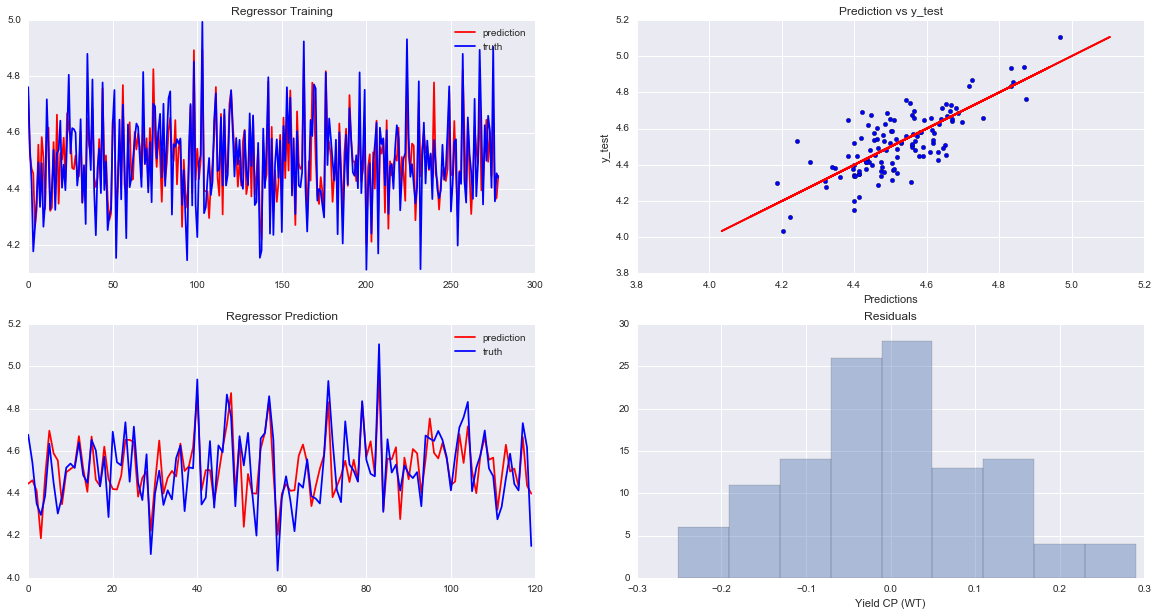

In [17]:
x_train, x_test, y_train, y_test = load_regression_data()

model = LinearRegression(fit_intercept=False)
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)

# P-Value might be different from the r_df table above because I might be slicing the data set differently 
# after selecting certain features.
x=0
print 'Coefficients and p-value:'
for i in model.coef_:
    print '{}: {}, {}'.format(x_train.columns[x],i,spStats.pearsonr(x_train[x_train.columns[x]], y_train.values)[1])
    x = x + 1
                              

print ''
print 'Training R-Squared:',model.score(x_train,y_train)
print 'Testing R-Squared:',model.score(x_test,y_test)


print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100


In [18]:
# joblib.dump(model,'models/Linear_Regression/Linear_Regression_Model.pkl')
print ''

# Decision Tree Regressor

Mean Squared Error: 0.0167742265529
Mean Absolute Error: 0.10464426687
Mean Absolute Error %: 2.31739442116


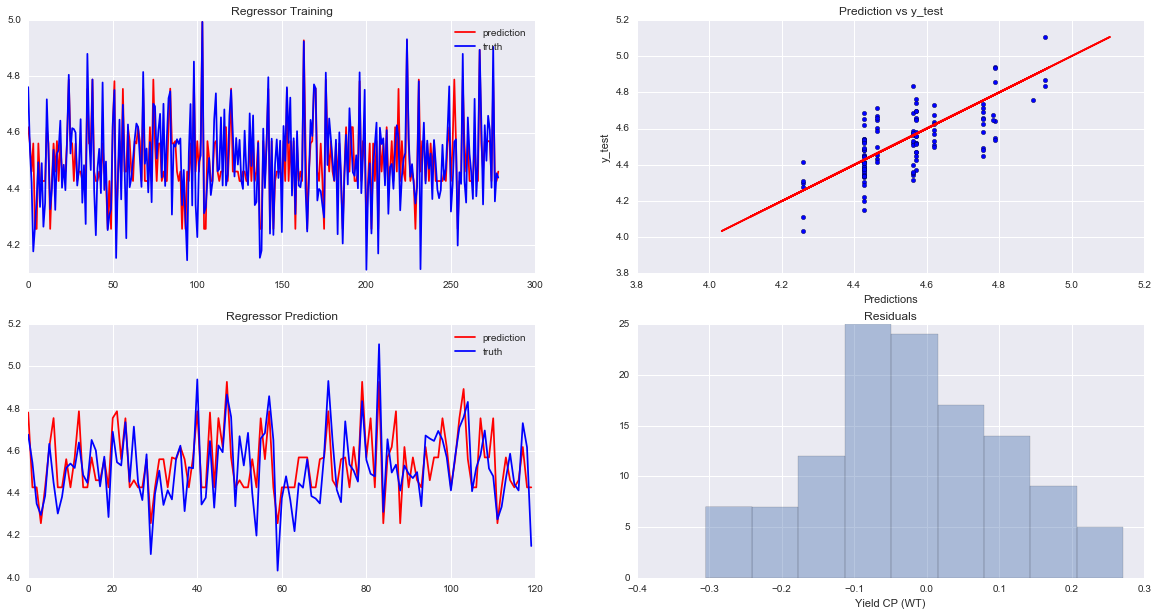

In [19]:
x_train, x_test, y_train, y_test = load_regression_data()

model = DecisionTreeRegressor(max_depth=4)
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)

print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

# Random Forest Regressor

Mean Squared Error: 0.0114421445077
Mean Absolute Error: 0.0840077365439
Mean Absolute Error %: 1.85981577581


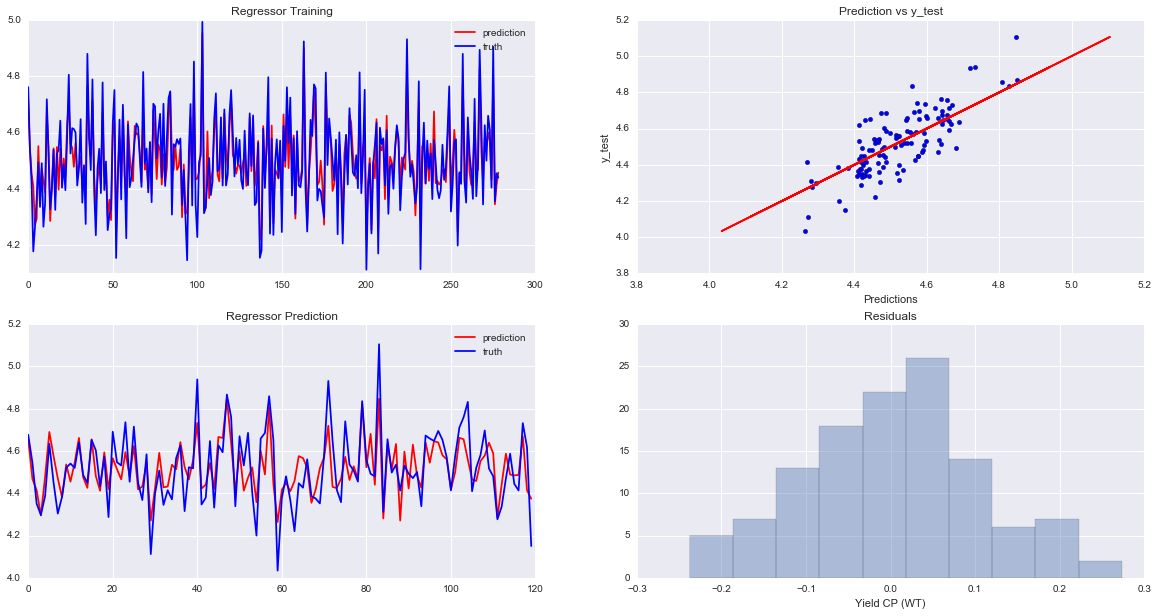

In [20]:
x_train, x_test, y_train, y_test = load_regression_data()

model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=1)
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)


print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

# Support Vector Regressor

Training R-Squared: -3152.16600706
Testing R-Squared: -3578.60800652
Mean Squared Error: 106.774230277
Mean Absolute Error: 6.98611638969


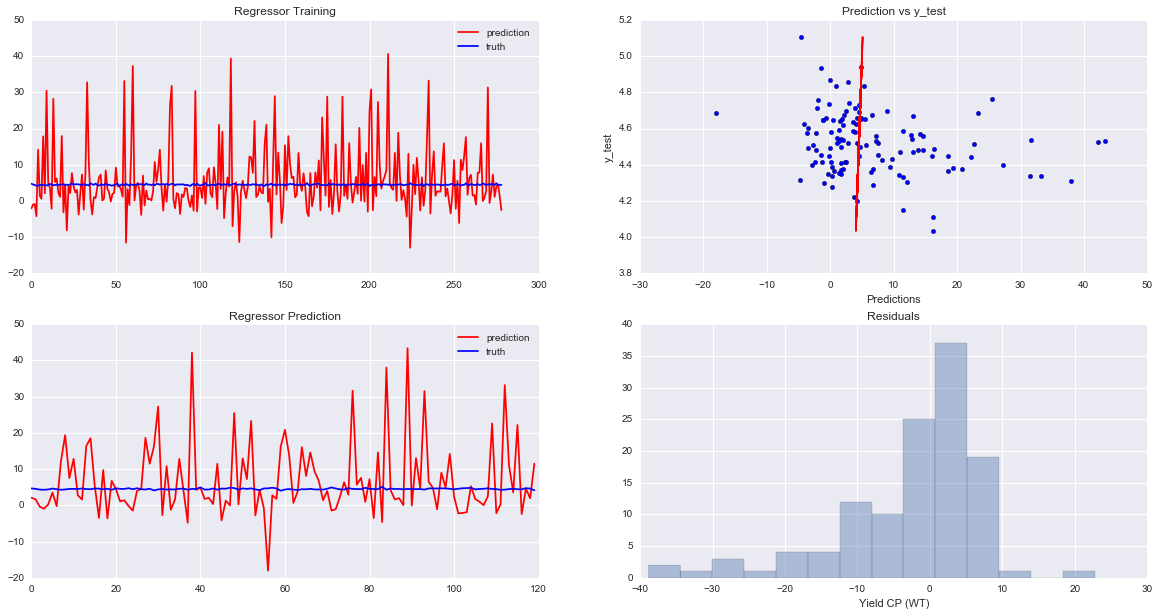

In [21]:
x_train, x_test, y_train, y_test = load_regression_data()

model = SVR(kernel='linear')
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)

print 'Training R-Squared:',model.score(x_train,y_train)
print 'Testing R-Squared:',model.score(x_test,y_test)

print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)

# Classification
Let's try classification. The target also has a complementary column with the following values.

In [22]:
# This is how my categorical target looks like
Counter(processed_df2[processed_df2['Year']!=2014]['15and16_yield_label'])

Counter({'above 1': 51, 'above mean': 90, 'below 1': 39, 'below mean': 111})

## Rescaling features: MinMaxScaler()
Let's rescale my data frame to see if it will yield better classification results.

In [23]:
rescaled_df = copy.deepcopy(processed_df2[processed_df2['Year']!=2014])
scaler = MinMaxScaler()
# scaler.fit_transform(rescaled_df.ix[:,7:])

for i in rescaled_df.columns:
    if 'numpy' in str(type(rescaled_df[[i]].iloc[0][0])):
        if i != 'Yield CP (WT)':
            rescaled_df[i] = scaler.fit_transform(rescaled_df[[i]])
rescaled_df.describe()

,Month,Year,Week No.,PCA (%),PPT G (kg),CPP (kg),g PPT G/kg CPP,Total Protein (g/dL),CUNO Filt (kg),VP (L),Diluted CPP (kg),Dilution (kg),CPP IgG before Fr1,Cuno IgG FP6,Diluted % Efficiency,CPP (L),G Conv (g IgG/Kg PPT G),Yield CP (WT),Yield VP (WT),I - Final pH,I - Aging,II+III After Alc pH,II+III After Alc Titer,II+III - Final pH,II+III - Aging,II+III Paste Wt,Buffer 1 Amt,Extraction Ratio,Extract - Final pH,Extract - Aging,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT,bag_or_bottle_label_Bags,bag_or_bottle_label_Bags/NMF,bag_or_bottle_label_Bottle,DilutedCPPvsCUNOFilt,DilutedCPPvsCUNOFilt_-1,DilutedCPPvsCUNOFilt_0,DilutedCPPvsCUNOFilt_1,Buffer 1 Percentage
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.0,291.000000,291.000000,291.000000
mean,0.377694,0.312715,0.381575,0.503480,0.519132,0.681982,0.502471,0.416764,0.704896,0.812003,0.455498,0.283919,0.571748,0.381393,0.449162,0.681982,0.003436,4.467894,0.540788,0.541728,0.229823,0.455459,0.459688,0.207456,0.220824,0.574274,0.695871,0.576473,0.428358,0.245156,0.463631,0.668112,0.494308,0.236013,0.134482,0.140758,0.098108,0.197618,0.287511,0.112041,0.587629,0.099656,0.312715,0.776632,0.0,0.223368,0.776632,0.539370
std,0.299807,0.464398,0.284793,0.171975,0.184069,0.157516,0.165810,0.135064,0.160434,0.116603,0.197758,0.304117,0.194394,0.150166,0.158136,0.157516,0.058621,0.141333,0.180161,0.192130,0.199988,0.190344,0.178801,0.117098,0.199075,0.141819,0.151898,0.095942,0.172457,0.166280,0.133279,0.110787,0.167739,0.188058,0.102005,0.122196,0.096668,0.087169,0.266791,0.119700,0.493109,0.300057,0.464398,0.417220,0.0,0.417220,0.417220,0.154620
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.034075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.181818,0.000000,0.153846,0.384615,0.389423,0.609099,0.395912,0.338346,0.596439,0.766247,0.329688,0.107766,0.443864,0.278182,0.355248,0.609099,0.000000,4.376847,0.415378,0.428571,0.098381,0.269231,0.307692,0.108696,0.060764,0.494318,0.625750,0.523441,0.347826,0.099057,0.416667,0.615385,0.406250,0.019606,0.060743,0.064295,0.032704,0.168378,0.000084,0.024964,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.439385
50%,0.363636,0.000000,0.326923,0.512821,0.509615,0.703666,0.491379,0.413534,0.710188,0.825620,0.388001,0.142019,0.595300,0.374545,0.443837,0.703666,0.000000,4.459501,0.536154,0.571429,0.135118,0.423077,0.461538,0.195652,0.190787,0.590909,0.715881,0.580183,0.434783,0.268868,0.472222,0.682051,0.531250,0.315928,0.132582,0.109684,0.062939,0.187081,0.481447,0.065991,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.526991
75%,0.454545,1.000000,0.480769,0.615385,0.639423,0.787863,0.612742,0.496241,0.826904,0.876188,0.474334,0.186915,0.704961,0.470909,0.536754,0.787863,0.000000,4.563199,0.666628,0.678571,0.305729,0.615385,0.615385,0.282609,0.334858,0.659091,0.790599,0.640882,0.521739,0.334906,0.500000,0.728205,0.593750,0.355242,0.174837,0.184765,0.146778,0.211402,0.505184,0.165299,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,1.000000,0.622534
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

In [24]:
def load_classification_data(randomState = 1):
    feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                       'CPP (kg)',
#                     'g PPT G/kg CPP',
                      'Total Protein (g/dL)',
                      'CUNO Filt (kg)',
                    'VP (L)',
                    'Diluted CPP (kg)',
#                     'Dilution (kg)',
                    'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
#                     'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
#                     'I - Final pH',
                    'I - Aging',
#                     'II+III After Alc pH',
                    'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
                    'Buffer 1 Amt',
                    'Buffer 1 Percentage',
#                     'Extraction Ratio',
#                     'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
# #                     'G_PPT_CT',
#                     'bag_or_bottle_label_Bags',
#                     'bag_or_bottle_label_Bags/NMF',
#                     'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]

# Comment out the pair of <features, target> rows to choose scaled or non-scaled data
#     features = processed_df2[processed_df2['Year']!=2014][feature_cols]
#     target = processed_df2[processed_df2['Year']!=2014]['15and16_yield_label']
    features = rescaled_df[feature_cols]
    target = rescaled_df['15and16_yield_label']

    return train_test_split(features,target,test_size=0.3, random_state=randomState)

# K Nearest Neighbors

In [25]:
x_train, x_test, y_train, y_test = load_classification_data()

model = KNeighborsClassifier(n_neighbors=6, weights='distance')
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model report:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model report:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model report:
             precision    recall  f1-score   support

    above 1       1.00      1.00      1.00        36
 above mean       1.00      1.00      1.00        67
    below 1       1.00      1.00      1.00        26
 below mean       1.00      1.00      1.00        74

avg / total       1.00      1.00      1.00       203

Test model report:
             precision    recall  f1-score   support

    above 1       0.80      0.27      0.40        15
 above mean       0.34      0.65      0.45        23
    below 1       0.38      0.23      0.29        13
 below mean       0.61      0.51      0.56        37

avg / total       0.54      0.47      0.46        88

Test model accuracy:
0.465909090909


# Random Forest

In [26]:
x_train, x_test, y_train, y_test = load_classification_data()

model = RandomForestClassifier(n_estimators=48, 
                               max_depth=6,
                               random_state=3, 
                               class_weight='balanced_subsample')
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model accuracy:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model accuracy:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model accuracy:
             precision    recall  f1-score   support

    above 1       1.00      0.97      0.99        36
 above mean       0.96      0.96      0.96        67
    below 1       1.00      0.88      0.94        26
 below mean       0.92      0.97      0.95        74

avg / total       0.96      0.96      0.96       203

Test model accuracy:
             precision    recall  f1-score   support

    above 1       0.55      0.40      0.46        15
 above mean       0.36      0.52      0.43        23
    below 1       0.50      0.62      0.55        13
 below mean       0.68      0.51      0.58        37

avg / total       0.55      0.51      0.52        88

Test model accuracy:
0.511363636364


In [27]:
# joblib.dump(model,'models/Random_Forest/Random_Forest_Model.pkl')
print ''

# Logistic Regression

In [28]:
x_train, x_test, y_train, y_test = load_classification_data(1)

model = LogisticRegression(fit_intercept=False, class_weight={'above 1':1,'above mean':1,'below 1':1,'below mean':1}, 
                           solver='lbfgs', multi_class='multinomial')
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model accuracy:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model accuracy:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model accuracy:
             precision    recall  f1-score   support

    above 1       0.61      0.31      0.41        36
 above mean       0.53      0.57      0.55        67
    below 1       0.00      0.00      0.00        26
 below mean       0.54      0.82      0.65        74

avg / total       0.48      0.54      0.49       203

Test model accuracy:
             precision    recall  f1-score   support

    above 1       0.40      0.13      0.20        15
 above mean       0.33      0.48      0.39        23
    below 1       0.00      0.00      0.00        13
 below mean       0.52      0.70      0.60        37

avg / total       0.37      0.44      0.39        88

Test model accuracy:
0.443181818182


C:\Users\leungr1\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Naive Bayes

In [29]:
x_train, x_test, y_train, y_test = load_classification_data(1)

model = GaussianNB()
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model accuracy:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model accuracy:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model accuracy:
             precision    recall  f1-score   support

    above 1       0.46      0.72      0.56        36
 above mean       0.60      0.37      0.46        67
    below 1       0.42      0.85      0.56        26
 below mean       0.67      0.46      0.54        74

avg / total       0.57      0.53      0.52       203

Test model accuracy:
             precision    recall  f1-score   support

    above 1       0.33      0.53      0.41        15
 above mean       0.44      0.35      0.39        23
    below 1       0.36      0.77      0.49        13
 below mean       0.78      0.38      0.51        37

avg / total       0.55      0.45      0.46        88

Test model accuracy:
0.454545454545


# Final Model Evaluation
For Regression, LinearRegression was the best model.

For Classification, Random Forest was the best model.

Due to the small amount of data and large amount of features, I can't use the k-folds cross_val_score() method to check model legitimacy. So instead, I wrote my own loop to change the "random_state" in the train_test_split() function, and look at the average score across multiple runs. 

In [30]:
# These are the models copied from above.
def LR_eval(x_train,x_test,y_train,y_test):
    model = LinearRegression(fit_intercept=False)
    model.fit(x_train,y_train)

    return model.score(x_test,y_test)

def RF_eval(x_train,x_test,y_train,y_test):
    model = RandomForestClassifier(n_estimators=20, 
                                   max_depth=5,
                                   random_state=1, 
                                   class_weight='balanced_subsample')
    model.fit(x_train,y_train)
    x_test_pred = model.predict(x_test)
    return metrics.accuracy_score(y_test,x_test_pred)

In [31]:
# Linear Regression Manual Cross Validation
overall_accuracy = []
numberOfRandomStates = 40

for i in range(numberOfRandomStates):
    x_train, x_test, y_train, y_test = load_regression_data(randomState=i)
    overall_accuracy.append(LR_eval(x_train,x_test,y_train,y_test))
print 'Mean R-Squared over 40 runs:',np.mean(overall_accuracy)
print 'Minimum R-Squared over 40 runs:',np.min(overall_accuracy)
print 'Maximum R-Squared over 40 runs:',np.max(overall_accuracy)

Mean R-Squared over 40 runs: 0.612093382515
Minimum R-Squared over 40 runs: 0.472006180507
Maximum R-Squared over 40 runs: 0.705330429365


In [32]:
# Random Forest Manual Corss Validation
overall_accuracy = []
numberOfRandomStates = 40

for i in range(numberOfRandomStates):
    x_train, x_test, y_train, y_test = load_classification_data(randomState=i)
    overall_accuracy.append(RF_eval(x_train,x_test,y_train,y_test))

print 'Mean Accuracy Score over 40 runs:',np.mean(overall_accuracy)
print 'Minimum Accuracy Score over 40 runs:',np.min(overall_accuracy)
print 'Maximum Accuracy Score over 40 runs:',np.max(overall_accuracy)

Mean Accuracy Score over 40 runs: 0.534375
Minimum Accuracy Score over 40 runs: 0.397727272727
Maximum Accuracy Score over 40 runs: 0.693181818182


# Chasing Accuracy: GridSearchCV
Now that the Random Forest classifier passed the custom cross validation test, let's chase accuracy.

In [33]:
params = {'n_estimators':range(18,23),
          'max_depth':range(4,7),
          'random_state': [1],
          'class_weight': ['balanced_subsample','balanced']
         }

# GridSearch

In [34]:
    feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                       'CPP (kg)',
#                     'g PPT G/kg CPP',
                      'Total Protein (g/dL)',
                      'CUNO Filt (kg)',
                    'VP (L)',
                    'Diluted CPP (kg)',
#                     'Dilution (kg)',
#                     'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
#                     'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
#                     'I - Final pH',
                    'I - Aging',
#                     'II+III After Alc pH',
                    'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
#                     'Buffer 1 Amt',
                    'Buffer 1 Percentage',
#                     'Extraction Ratio',
                    'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
# #                     'G_PPT_CT',
#                     'bag_or_bottle_label_Bags',
                    'bag_or_bottle_label_Bags/NMF',
#                     'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]

In [35]:
gs = grid_search.GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid=params,cv=5,
                              scoring='accuracy')

gs.fit(processed_df2[processed_df2['Year']!=2014][feature_cols],
       processed_df2[processed_df2['Year']!=2014]['15and16_yield_label'])
print 'best score:',gs.best_score_
print 'best params:',gs.best_params_

best score: 0.518900343643
best params: {'n_estimators': 18, 'random_state': 1, 'max_depth': 6, 'class_weight': 'balanced_subsample'}


Even though grid search gave me the best parameters, I tried out the 40 runs validation with the new parameters, they turned out to be a little worse than what I originally had. I think it maybe due to how GridSearchCV divides the data into the k-folds. Running it multiple times also yielded the same score, so I'm guessing it's not randomizing how the data is divided.

# PCA

In [36]:
feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                       'CPP (kg)',
#                     'g PPT G/kg CPP',
                  'Total Protein (g/dL)',
                  'CUNO Filt (kg)',
                'VP (L)',
                'Diluted CPP (kg)',
#                     'Dilution (kg)',
#                     'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
#                     'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
#                     'I - Final pH',
                'I - Aging',
#                     'II+III After Alc pH',
                'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
#                     'Buffer 1 Amt',
                'Buffer 1 Percentage',
#                     'Extraction Ratio',
                'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
# #                     'G_PPT_CT',
#                     'bag_or_bottle_label_Bags',
                'bag_or_bottle_label_Bags/NMF',
#                     'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                'DilutedCPPvsCUNOFilt_0',
                'DilutedCPPvsCUNOFilt_1'
                ]

Components importance: [ 0.612085    0.14317426  0.06284152]
Mean Squared Error: 0.0163386238344
Mean Absolute Error: 0.10429827905
Mean Absolute Error %: 2.33926081351


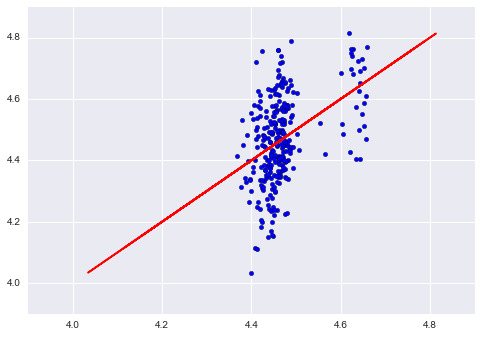

In [37]:
# PCA is not prone to overfitting, so I can fit a PCA with my entire data set and no need to do train_test_split()
pca = decomposition.PCA(n_components=3)
new_features = pca.fit_transform(rescaled_df[feature_cols])

print 'Components importance:', pca.explained_variance_ratio_

model=LinearRegression()
model.fit(new_features,rescaled_df['Yield CP (WT)'])

# Now that it's trained, we need to pca transform our x_test data, feed the new pca into the prediction,
# and compare it with y_test.

pred = model.predict(new_features)
residual = rescaled_df['Yield CP (WT)'] - pred

plt.scatter(pred,rescaled_df['Yield CP (WT)'])
plt.plot(rescaled_df['Yield CP (WT)'],rescaled_df['Yield CP (WT)'],'r')

print 'Mean Squared Error:',metrics.mean_squared_error(rescaled_df['Yield CP (WT)'],pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(rescaled_df['Yield CP (WT)'],pred)
print 'Mean Absolute Error %:', sum(abs((rescaled_df['Yield CP (WT)']-pred) / rescaled_df['Yield CP (WT)']) / len(rescaled_df['Yield CP (WT)']))*100

Using PCA to reduce the dimensions of my data set down to 3 yielded bigger MSE and MAE. This might be due to my non-normalized numerical data. Some of my features are in the thousands whereas some are in the tens. To improve PCA, I may need to run it again with normalized data.

# Neural Networks

## Regression

In [38]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

In [234]:
feature_cols = [
    #                     'Bag/Bottle',
    #                     'PCA (%)',
    #                     'PPT G (kg)',
    #                       'CPP (kg)',
    #                     'g PPT G/kg CPP',
    'Total Protein (g/dL)',
    'CUNO Filt (kg)',
#     'VP (L)',
    'Diluted CPP (kg)',
    #                     'Dilution (kg)',
#                         'CPP IgG before Fr1',
    #                     'Cuno IgG FP6',
    #                     'Diluted % Efficiency',
    #                     'CPP (L)',
    #                     'G Conv (g IgG/Kg PPT G)',
    #                     'Yield CP (WT)',
    #                     'Yield_Label',
    #                     'Yield_Label_2',
    #                     'Yield VP (WT)',
    #                     'I - Final pH',
    'I - Aging',
    #                     'II+III After Alc pH',
    'II+III After Alc Titer',
    #                     'II+III - Final pH',
    #                     'II+III - Aging',
    #                     'II+III Paste Wt',
    #                     'Buffer 1 Amt',
#     'Buffer 1 Percentage',
    #                     'Extraction Ratio',
    'Extract - Final pH',
    #                     'Extract - Aging',
    #                     'G - Init pH',
    #                     'G - titer',
    #                     'G - Final pH',
    #                     'G - Aging',
    #                     'TD_CT',
    #                     'FrI_PPT_CT',
    #                     'FrII_PPT_CT',
    #                     'V13_Sep_CT',
    #                     'Ext_PPT_CT',
    # #                     'G_PPT_CT',
    #                     'bag_or_bottle_label_Bags',
#     'bag_or_bottle_label_Bags/NMF',
#                         'bag_or_bottle_label_Bottle',
#                         'DilutedCPPvsCUNOFilt',
#                         'DilutedCPPvsCUNOFilt_-1',
#     'DilutedCPPvsCUNOFilt_0',
#     'DilutedCPPvsCUNOFilt_1'
]
print 'Number of features:',len(feature_cols)
features = np.array(rescaled_df[feature_cols])
target = np.array(rescaled_df[['Yield CP (WT)']])
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = .5)

Number of features: 6


In [235]:
model = Sequential()
model.add(Dense(input_dim = 6, output_dim = 12, activation='relu'))
model.add(Dense(input_dim = 12, output_dim = 12, activation='relu'))
model.add(Dense(input_dim = 12, output_dim = 12, activation='relu'))
model.add(Dense(input_dim = 12, output_dim = 12, activation='relu'))
model.add(Dense(input_dim = 12, output_dim = 1, activation='linear'))

model.compile(optimizer=SGD(lr=0.0004), loss='mae')

print "Training..."
startTime = timeit.default_timer()
model_history = model.fit(x_train,y_train,nb_epoch=70000,verbose=False)
print "Done. Training Time:", timeit.default_timer() - startTime

Training...
Done. Training Time: 422.661482041


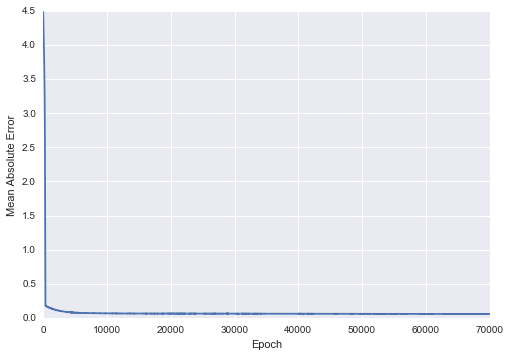

In [236]:
# Plotting the neural network training loss history
plt.plot(model_history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')

Mean Squared Error: 0.00955129275648
Mean Absolute Error: 0.071147964085


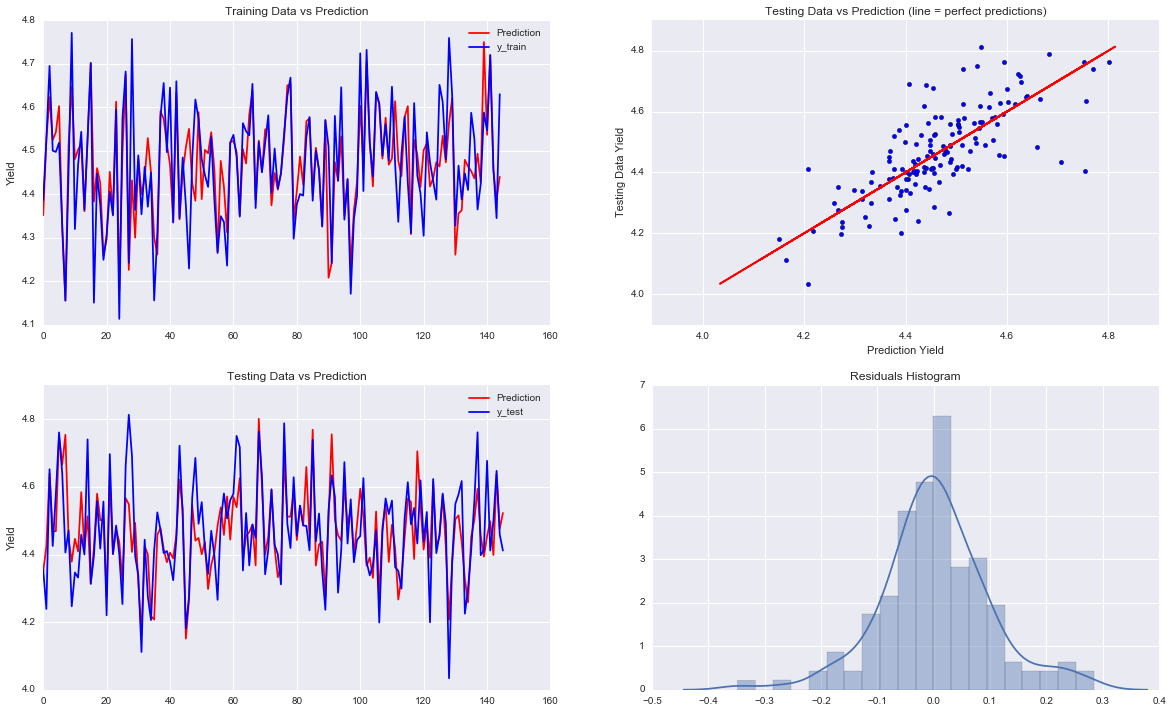

In [237]:
train_pred = model.predict(x_train)

test_pred = model.predict(x_test)
residuals = y_test-test_pred


fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,12))

# Charting
axes[0,0].plot(range(len(train_pred)),train_pred,'r',label='Prediction')
axes[0,0].plot(range(len(y_train)),y_train,'b',label='y_train')
axes[0,0].set_title('Training Data vs Prediction')
axes[0,0].set_ylabel('Yield')
axes[0,0].legend()

axes[1,0].plot(range(len(test_pred)),test_pred,'r',label='Prediction')
axes[1,0].plot(range(len(y_test)),y_test,'b',label='y_test')
axes[1,0].set_title('Testing Data vs Prediction')
axes[1,0].set_ylabel('Yield')
axes[1,0].legend()

axes[0,1].scatter(test_pred,y_test)
axes[0,1].plot(y_test,y_test,'r')
axes[0,1].set_xlabel('Prediction Yield')
axes[0,1].set_ylabel('Testing Data Yield')
axes[0,1].set_title('Testing Data vs Prediction (line = perfect predictions)')

sns.distplot(residuals,ax=axes[1,1], bins=20)
plt.title('Residuals Histogram')

print 'Mean Squared Error:',metrics.mean_squared_error(y_test,test_pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,test_pred)

In [239]:
# model.save('models/Neural_Network_Regression/neural_network_model.h5')

## Classification

In [227]:
feature_cols = [
    #                     'Bag/Bottle',
    #                     'PCA (%)',
    #                     'PPT G (kg)',
    #                       'CPP (kg)',
    #                     'g PPT G/kg CPP',
    'Total Protein (g/dL)',
    'CUNO Filt (kg)',
#     'VP (L)',
    'Diluted CPP (kg)',
    #                     'Dilution (kg)',
#                         'CPP IgG before Fr1',
    #                     'Cuno IgG FP6',
    #                     'Diluted % Efficiency',
    #                     'CPP (L)',
    #                     'G Conv (g IgG/Kg PPT G)',
    #                     'Yield CP (WT)',
    #                     'Yield_Label',
    #                     'Yield_Label_2',
    #                     'Yield VP (WT)',
    #                     'I - Final pH',
    'I - Aging',
    #                     'II+III After Alc pH',
    'II+III After Alc Titer',
    #                     'II+III - Final pH',
    #                     'II+III - Aging',
    #                     'II+III Paste Wt',
    #                     'Buffer 1 Amt',
#     'Buffer 1 Percentage',
    #                     'Extraction Ratio',
    'Extract - Final pH',
    #                     'Extract - Aging',
    #                     'G - Init pH',
    #                     'G - titer',
    #                     'G - Final pH',
    #                     'G - Aging',
    #                     'TD_CT',
    #                     'FrI_PPT_CT',
    #                     'FrII_PPT_CT',
    #                     'V13_Sep_CT',
    #                     'Ext_PPT_CT',
    # #                     'G_PPT_CT',
    #                     'bag_or_bottle_label_Bags',
#     'bag_or_bottle_label_Bags/NMF',
#                         'bag_or_bottle_label_Bottle',
#                         'DilutedCPPvsCUNOFilt',
#                         'DilutedCPPvsCUNOFilt_-1',
#     'DilutedCPPvsCUNOFilt_0',
#     'DilutedCPPvsCUNOFilt_1'
]
print 'Number of features:',len(feature_cols)
features = np.array(rescaled_df[feature_cols])

tempDict = {'below 1':0,'below mean':1,'above mean':2,'above 1':3}
target = rescaled_df['15and16_yield_label'].apply(lambda x: tempDict[x])

# Breaking each label into indicator columns, that's what Keras want.
target = pd.get_dummies(target)

target = np.array(target)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = .35)

Number of features: 6


In [228]:
model = Sequential()
model.add(Dense(input_dim=6,output_dim=12,activation='relu'))
model.add(Dense(output_dim=12,activation='relu'))
model.add(Dense(output_dim=12,activation='relu'))
model.add(Dense(output_dim=12,activation='relu'))
model.add(Dense(output_dim=12,activation='relu'))
model.add(Dense(output_dim=4,activation='softmax'))

RMS = RMSprop(lr=0.0002)

model.compile(loss='categorical_crossentropy', optimizer=RMS)

print "Training..."
startTime = timeit.default_timer()
model_history = model.fit(x_train,y_train,nb_epoch=20000,verbose=False)
print "Done. Training Time:", timeit.default_timer() - startTime

Training...
Done. Training Time: 196.92699192


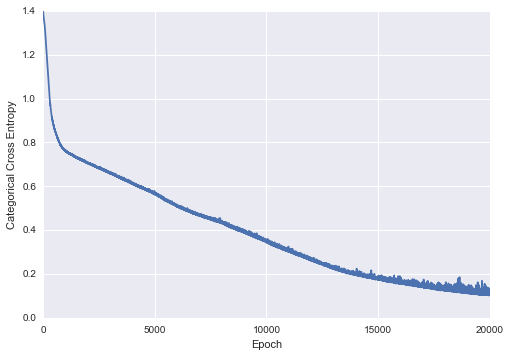

In [233]:
plt.plot(model_history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')

In [230]:
test_pred = model.predict_classes(x_test, verbose=False)
# test_pred = model.predict(x_test)

# Collapsing the categorical columns back into one column
# 'below 1':0,'below mean':1,'above mean':2,'above 1':3
y_testList = []
for i in y_test:
    if i[0]:
        y_testList.append(0)
    elif i[1]:
        y_testList.append(1)
    elif i[2]:
        y_testList.append(2)
    elif i[3]:
        y_testList.append(3)

print 'Confusion Matrix Scores:'
print metrics.classification_report(y_testList,test_pred)
print ''
print 'Accuracy Score:'
print metrics.accuracy_score(y_testList,test_pred)

Confusion Matrix Scores:
             precision    recall  f1-score   support

          0       0.50      0.46      0.48        13
          1       0.54      0.72      0.62        36
          2       0.52      0.47      0.49        32
          3       0.54      0.33      0.41        21

avg / total       0.53      0.53      0.52       102


Accuracy Score:
0.529411764706


In [232]:
# model.save('models/Neural_Network_Classification/neural_network_classification.h5')

# Study Summary
Regression and classification techniques were used to create models that try to make some sort of prediction with both the numerical and categorical targets. Some feature engineering techniques were also used, such as K-MEANs / DBSCAN and creating dummy variables for categorical features, in hopes of creating an accurate model.

For regression models, the best algorithm is Linear Regression according to mean-squared and mean-absolute errors. 

For classification models, the best algorithm is Random Forest according to the confusion matrix and overall classification accuracy.

A Neural Network regressor is also built to compare with Linear Regression model.

To validate the two models, a custom cross-validation method was used. I ran the model with 40 sets of different train/test/split data, and the average accuracy was also assessed over the 40 runs:
* **Linear Regression (40 runs)**
    * R-Square value:0.612
    * Mean Absolute Error: 0.09 (target standard deviation = 0.14)
* **Neural Network Regression**
    * Mean Absolute Error: 0.0724 (target standard deviation = 0.14)
* **Random Forest Classification (40 runs)**
    * Accuracy score: 0.53
    * With 4 different classes, a completely random model will give a 0.25 accuracy rate, so a 0.53 accuracy rate is not too bad.
* **Neural Network Classification**
    * Similar results to Random Forest Classification, but takes longer to train.

In attempt to further increase accuracy for Random Forest, GridSearchCV was used, but I am not too sure of the results because cross-validation doesn't split up the k-folds randomly.

PCA is also conducted to see if we can get just as good of a model with a lower dimension feature set. But when we compare the error metrics with the original Linear Regression model's, the PCA Linear Regression model has worse performance.

# Conclusion
I am satisfied with creating two somewhat accurate models. With a R-Squared value of **0.612 for Linear Regression**, the model has some predictive power. It might not be exact, but it should predict the trend accurately. The mean absolute error is 0.09 vs the target's standard deviation of 0.14. 

For the **Neural Network regressor, I had an MAE of 0.0724**, which is better than the Linear Regressor's performance. 

For **classification, the accuracy score is 0.53**, and looking at the confusion matrix, the precision and recall metrics seem to be fairly balanced among the four classes. 

To advance this study further and chase accuaracy, I will need to get with my data team and to get more samples, or identify other features that have more impact to the targets. And if I have enough data, I will try using a Neural Network model to see if it can perform better than the Linear Regression and Random Forest models.